<a href="https://colab.research.google.com/github/jash0803/ai-for-social-good-acm-summer-school/blob/main/ssl_on_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Self-supervised learning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import necessary libraries

In [ ]:
import matplotlib.pyplot as plt
import torchvision
from torchvision.datasets import CIFAR10
import torchvision.transforms as T
import numpy as np
from PIL import Image
import torchvision.models as models
import random
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision.models import resnet18
from torchvision.models.resnet import ResNet, BasicBlock
import tqdm
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torch.optim as optim
from rich.console import Console
from rich.table import Table
from torchvision import datasets
from torchvision.transforms import ToPILImage
import warnings
warnings.filterwarnings('ignore')


### Data collection

In [ ]:
cifar_10_dataset = CIFAR10(root='./data', train=True, download=True)

100%|██████████| 170M/170M [00:04<00:00, 42.3MB/s]


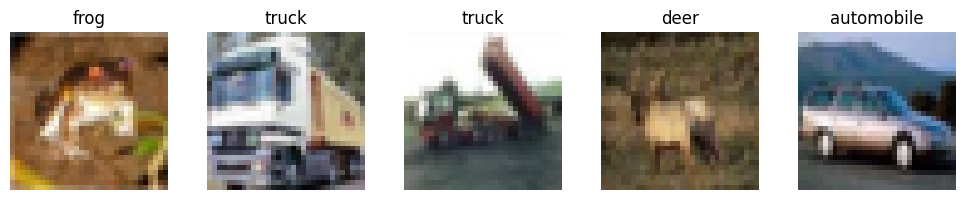

In [ ]:
class_names = cifar_10_dataset.classes
plt.figure(figsize=(10, 2))
for i in range(5):
    image, label = cifar_10_dataset[i]
    plt.subplot(1, 5, i+1)
    plt.imshow(np.array(image))
    plt.title(class_names[label])
    plt.axis('off')
plt.tight_layout()


### Pretext dataset

In [ ]:
class RotNetDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.rotations = [0, 90, 180, 270]
        self.transform = T.Compose([
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]
        rotation = random.choice(self.rotations)
        rotated_img = T.functional.rotate(img, rotation)
        label = self.rotations.index(rotation)
        return self.transform(rotated_img), label

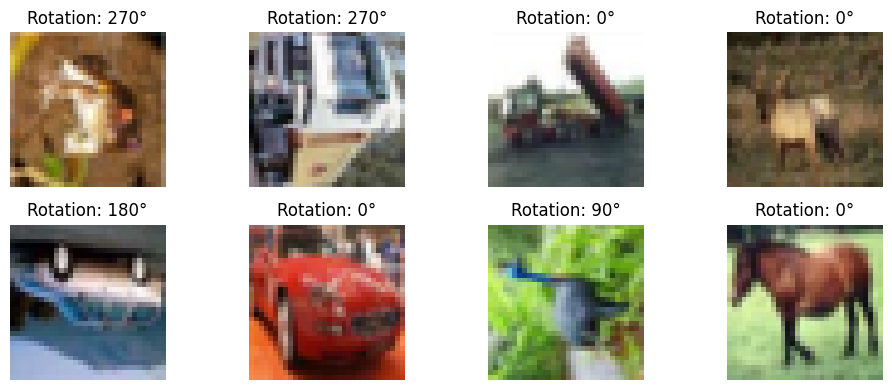

In [ ]:
ssl_dataset = RotNetDataset(cifar_10_dataset)
pretext_loader = DataLoader(ssl_dataset, batch_size=64, shuffle=True)
plt.figure(figsize=(10, 4))
for i in range(8):
    image_tensor, label = ssl_dataset[i]
    image = image_tensor.permute(1, 2, 0).numpy()  # Convert CHW → HWC for matplotlib

    plt.subplot(2, 4, i + 1)
    plt.imshow(image)
    plt.title(f"Rotation: {label * 90}°")
    plt.axis('off')

plt.tight_layout()

### Pretext Model

In [ ]:
class ResNetRotationPredictor(nn.Module):
    def __init__(self, num_classes=4):  # 4 classes: 0°, 90°, 180°, 270°
        super().__init__()
        self.encoder = resnet18(pretrained=True)

        # Modify first conv to accept 3-channel CIFAR-10 images if needed
        self.encoder.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.encoder.maxpool = nn.Identity()  # Remove maxpool to retain CIFAR-10 resolution

        # Replace classifier head
        self.encoder.fc = nn.Linear(self.encoder.fc.in_features, num_classes)

    def forward(self, x):
        return self.encoder(x)

In [ ]:
console = Console()

# DataLoader
train_loader = DataLoader(ssl_dataset, batch_size=1024, shuffle=True,num_workers=8)

# Setup
device='cuda' if torch.cuda.is_available() else 'cpu'
model = ResNetRotationPredictor().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training
console.rule("[bold green]Rotation Prediction Training (Self-Supervised)")
epoch_cnt = 3

for epoch in range(1, epoch_cnt):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    loop = tqdm.tqdm(train_loader, desc=f"Epoch {epoch:02d}", leave=False)

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        loop.set_postfix(loss=loss.item(), acc=100. * correct / total)

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total

    console.print(f"[cyan]Epoch {epoch:02d}[/cyan] - "
                  f"[yellow]Loss:[/yellow] {epoch_loss:.4f}  "
                  f"[green]Accuracy:[/green] {epoch_acc:.2f}%")

console.rule("[bold green]Training complete!")


───────────────────────────────── Rotation Prediction Training (Self-Supervised) ──────────────────────────────────

Epoch 01 - Loss: 0.8953  Accuracy: 63.05%

Epoch 02 - Loss: 0.5431  Accuracy: 78.88%

─────────────────────────────────────────────── Training complete! ────────────────────────────────────────────────

### Downstream Model

In [ ]:
class CIFAR10Classifier(nn.Module):
    def __init__(self, pretrained_encoder, num_classes=10, freeze_encoder=True):
        super().__init__()
        self.encoder = pretrained_encoder

        if freeze_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False

        # Replace the classification head
        self.encoder.fc = nn.Linear(self.encoder.fc.in_features, num_classes)

    def forward(self, x):
        return self.encoder(x)

In [ ]:
# Standard transforms for classification
transform = T.Compose([
    T.ToTensor(),
])
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset  = CIFAR10(root='./data', train=False, download=True, transform=transform)
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=8)
test_loader  = DataLoader(test_dataset, batch_size=1024, shuffle=False, num_workers=8)

Number of training samples: 50000
Number of test samples: 10000


In [ ]:
# Use the encoder from your trained RotNet model
pretrained_encoder = model.encoder
clf_model = CIFAR10Classifier(pretrained_encoder, freeze_encoder=False).to(device)


You’ve seen how `freeze_encoder=False` means the encoder *gets off the couch and hits the gym* 🏋️‍♂️ (i.e., it's trainable).  
But if you write `freeze_encoder=True`, you're basically telling the encoder:  
> "Take a nap, buddy. You're off duty!" 😴

In [ ]:
# Train the model
console = Console()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(clf_model.parameters(), lr=1e-3)

console.rule("[bold blue]Training Classifier on CIFAR-10")

for epoch in range(1, 11):
    clf_model.train()
    running_loss, correct, total = 0.0, 0, 0

    loop = tqdm.tqdm(train_loader, desc=f"[Epoch {epoch:02d}]", leave=False, ncols=90)

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        outputs = clf_model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        current_acc = 100. * correct / total
        loop.set_postfix(loss=loss.item(), acc=current_acc)

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total

    console.print(f"[cyan]Epoch {epoch:02d}[/cyan] "
                  f"Loss: [yellow]{epoch_loss:.4f}[/yellow]  "
                  f"Accuracy: [green]{epoch_acc:.2f}%[/green]")

console.rule("[bold green] Training Complete!")


───────────────────────────────────────── Training Classifier on CIFAR-10 ─────────────────────────────────────────

Epoch 01 Loss: 1.5383  Accuracy: 45.45%

Epoch 02 Loss: 1.1064  Accuracy: 61.61%

Epoch 03 Loss: 1.0149  Accuracy: 64.51%

Epoch 04 Loss: 0.9630  Accuracy: 66.35%

Epoch 05 Loss: 0.9290  Accuracy: 67.63%

Epoch 06 Loss: 0.9031  Accuracy: 68.45%

Epoch 07 Loss: 0.8815  Accuracy: 69.14%

Epoch 08 Loss: 0.8681  Accuracy: 69.57%

Epoch 09 Loss: 0.8529  Accuracy: 70.12%

Epoch 10 Loss: 0.8410  Accuracy: 70.49%

───────────────────────────────────────────────  Training Complete! ───────────────────────────────────────────────

In [ ]:
#Model Evaluation
clf_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = clf_model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_acc = 100.0 * correct / total
print(f"✅ Test Accuracy: {test_acc:.2f}%")

✅ Test Accuracy: 69.85%


### Now Your Turn 😎



# Jigsaw puzzle pretext task


## Generate the pretext dataset

In [ ]:
# Write code to generate data of jigsaw puzzle pretraining task

Permutation Index: 4


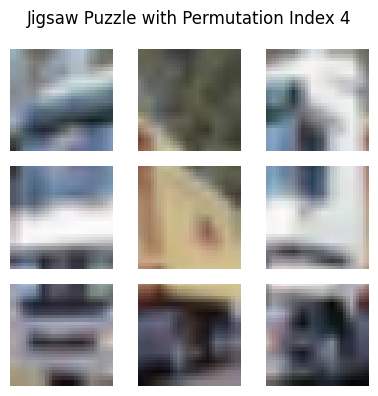

In [ ]:
#Visualization
transform = T.Compose([
    T.Resize((96, 96)),
    T.ToTensor()
])
jigsaw_dataset = JigsawDataset(cifar_10_dataset, transform=transform)
tiles_tensor, perm_index = jigsaw_dataset[1]
print(f"Permutation Index: {perm_index}")
fig, axs = plt.subplots(3, 3, figsize=(4, 4))
for idx, ax in enumerate(axs.flat):
    tile = tiles_tensor[idx].permute(1, 2, 0).numpy()
    ax.imshow(tile)
    ax.axis('off')
plt.suptitle(f"Jigsaw Puzzle with Permutation Index {perm_index}")
plt.tight_layout()
plt.show()

### Define the Pretext Model

In [ ]:
class JigsawNet(nn.Module):
    def __init__(self, num_permutations=9):
        super().__init__()
        self.tile_cnn = resnet18(pretrained=False)
        self.tile_cnn.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.tile_cnn.maxpool = nn.Identity()
        self.tile_cnn.fc = nn.Identity()  # feature extractor

        self.classifier = nn.Sequential(
            nn.Linear(512 * 9, 1024),
            nn.ReLU(),
            nn.Linear(1024, num_permutations)
        )

    def forward(self, x):  # x shape: [B, 9, C, H, W]
        B = x.size(0)
        tiles = x.view(B * 9, 3, x.size(3), x.size(4))
        features = self.tile_cnn(tiles)  # shape: [B*9, 512]
        features = features.view(B, -1)  # shape: [B, 512*9]
        out = self.classifier(features)
        return out


### Now Your Turn: Jigsaw Puzzle Challenge

For this homework task, your goal is to train a model on a jigsaw puzzle pretext task. The twist? Your dataset should be transformed so that each image is resized to 96x96. This will ensure consistency and compatibility during training.

A few tips before you begin:

- Set `freeze_encoder=False` if you want the encoder to learn from scratch and update its weights.
- Set `freeze_encoder=True` if you want to keep the encoder frozen (no learning from this task).

Remember, the goal is to shuffle and reassemble patches like a jigsaw puzzle. Think of it as a brain teaser — except your model is doing the thinking.




In [ ]:
#Downstream Classifier

class CIFAR10Classifier(nn.Module):
    def __init__(self, pretrained_encoder, num_classes=10, freeze_encoder=True):
        super().__init__()
        self.encoder = pretrained_encoder

        # Get in_features before replacing the layer
        in_features = getattr(self.encoder.fc, 'in_features', 512)  # default fallback

        if freeze_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False

        # Replace the classification head
        self.encoder.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.encoder(x)

In [ ]:
#Train loop - Task
#Evaluate Loop -Task

# Contrastive Method: SimClR

In [ ]:
# Generate Pretext Dataset
class SimCLRTransform:
    def __init__(self, image_size=32):
        self.transform = T.Compose([
            T.RandomResizedCrop(size=image_size),
            T.RandomHorizontalFlip(),
            T.RandomApply([T.ColorJitter(0.8, 0.8, 0.8, 0.2)], p=0.8),
            T.RandomGrayscale(p=0.2),
            T.GaussianBlur(kernel_size=3),
            T.ToTensor(),
        ])

    def __call__(self, x):
        return self.transform(x), self.transform(x)


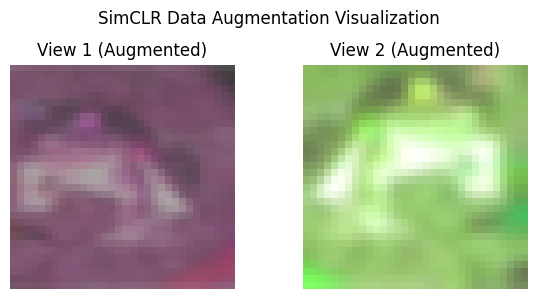

In [ ]:
# Define the SimCLR data augmentations
class SimCLRTransform:
    def __init__(self, image_size=32):
        self.transform = T.Compose([
            T.RandomResizedCrop(size=image_size, scale=(0.5, 1.0)),
            T.RandomHorizontalFlip(),
            T.RandomApply([T.ColorJitter(0.8, 0.8, 0.8, 0.2)], p=0.8),
            T.RandomGrayscale(p=0.2),
            T.GaussianBlur(kernel_size=3),
            T.ToTensor()
        ])

    def __call__(self, x):
        return self.transform(x), self.transform(x)

# Load CIFAR10 and apply the SimCLRTransform
simclr_transform = SimCLRTransform()
dataset = datasets.CIFAR10(root='./data', train=True, transform=simclr_transform, download=True)

# Get one sample image and apply two augmentations
(img1, img2), _ = dataset[0]

# Convert tensors to PIL for plotting
to_pil = ToPILImage()
img1_pil = to_pil(img1)
img2_pil = to_pil(img2)

# Plot the original image and its two augmented views
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(img1_pil)
axs[0].set_title('View 1 (Augmented)')
axs[0].axis('off')

axs[1].imshow(img2_pil)
axs[1].set_title('View 2 (Augmented)')
axs[1].axis('off')

plt.suptitle("SimCLR Data Augmentation Visualization")
plt.tight_layout()
plt.show()


In [ ]:
# Pretext Model
import torchvision.models as models
class SimCLR(nn.Module):
    def __init__(self, base_model='resnet18', out_dim=128):
        super().__init__()
        self.encoder = models.__dict__[base_model](pretrained=False)
        self.encoder.fc = nn.Identity()  # Remove classification head

        # Projection Head
        self.projection = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, out_dim)
        )

    def forward(self, x):
        h = self.encoder(x)
        z = self.projection(h)
        return z

In [ ]:
#Loss Function define
def nt_xent_loss(z_i, z_j, temperature=0.5):
    batch_size = z_i.size(0)
    z = torch.cat([z_i, z_j], dim=0)  # [2N, D]
    z = F.normalize(z, dim=1)

    similarity_matrix = torch.matmul(z, z.T)  # [2N, 2N]
    labels = torch.arange(batch_size).repeat(2).to(z.device)
    labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()

    mask = torch.eye(labels.shape[0], dtype=torch.bool).to(z.device)
    labels = labels[~mask].view(labels.shape[0], -1)
    similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)

    positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)
    negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1)

    logits = torch.cat([positives, negatives], dim=1)
    labels = torch.zeros(logits.shape[0], dtype=torch.long).to(z.device)

    return F.cross_entropy(logits / temperature, labels)


In [ ]:
#train the SimCLR model
transform = SimCLRTransform()
dataset = CIFAR10(root='./data', train=True, transform=transform, download=True)
loader = DataLoader(dataset, batch_size=1024, shuffle=True, num_workers=4, drop_last=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimCLR().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
from tqdm import tqdm
from rich.console import Console
console = Console()
console.rule("[bold cyan]Training SimCLR Model")
epoch_cnt = 3
for epoch in range(1, epoch_cnt):
    model.train()
    running_loss = 0.0
    loop = tqdm(loader, desc=f"[Epoch {epoch:02d}]", leave=False, ncols=90)

    for (img1, img2), _ in loop:
        img1, img2 = img1.to(device), img2.to(device)

        optimizer.zero_grad()
        z_i = model(img1)
        z_j = model(img2)

        loss = nt_xent_loss(z_i, z_j)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * img1.size(0)
        loop.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(loader.dataset)
    console.print(f"[cyan]Epoch {epoch:02d}[/cyan] - Loss: [yellow]{epoch_loss:.4f}[/yellow]")

────────────────────────────────────────────── Training SimCLR Model ──────────────────────────────────────────────

Epoch 01 - Loss: 6.7465

Epoch 02 - Loss: 6.4358

In [ ]:
class CIFAR10Classifier(nn.Module):
    def __init__(self, pretrained_encoder, num_classes=10, freeze_encoder=True):
        super().__init__()
        self.encoder = pretrained_encoder
        in_features = getattr(self.encoder.fc, 'in_features', 512)
        if freeze_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False
        self.encoder.fc = nn.Linear(in_features, num_classes)
    def forward(self, x):
        return self.encoder(x)


In [ ]:
# Use the encoder from your trained SimCLR model
pretrained_encoder = model.encoder
# Create classifier using this encoder
clf_model = CIFAR10Classifier(pretrained_encoder, freeze_encoder=False).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(clf_model.parameters(), lr=1e-3)
console.rule("[bold blue]Training Classifier with SimCLR Pretrained Encoder")
epoch_cnt = 3
for epoch in range(1, epoch_cnt):
    clf_model.train()
    running_loss, correct, total = 0.0, 0, 0

    #loop = tqdm.tqdm(train_loader, desc=f"[Epoch {epoch:02d}]", leave=False, ncols=90)

    for batch in tqdm(train_loader):
        images, labels = batch[0].to(device), batch[1].to(device)

        outputs = clf_model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        loop.set_postfix(loss=loss.item(), acc=100. * correct / total)

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total

    console.print(f"[blue]Epoch {epoch:02d}[/blue] - "
                  f"[yellow]Loss:[/yellow] {epoch_loss:.4f}  "
                  f"[green]Accuracy:[/green] {epoch_acc:.2f}%")
console.rule("[bold green]✅ Training Complete (SimCLR Pretrained Encoder)")


─────────────────────────────── Training Classifier with SimCLR Pretrained Encoder ────────────────────────────────

100%|██████████| 49/49 [00:18<00:00,  2.72it/s]


Epoch 01 - Loss: 1.5379  Accuracy: 43.99%

100%|██████████| 49/49 [00:18<00:00,  2.66it/s]


Epoch 02 - Loss: 1.1000  Accuracy: 60.37%

──────────────────────────────── ✅ Training Complete (SimCLR Pretrained Encoder) ─────────────────────────────────

In [ ]:
checkpoint_path ="/content/drive/MyDrive/ssl_onvision/dino-cifar10-0g6ueiuu-ep=39.ckpt"


In [ ]:
# Load checkpoint (map_location is important if not using GPU)
ckpt = torch.load(checkpoint_path, map_location="cpu")
# Check available keys
print("Checkpoint keys:", ckpt.keys())


# Extract encoder state dict
state_dict = ckpt["state_dict"]
encoder_state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items() if k.startswith("backbone")}
# encoder_state_dict
# Load into torchvision resnet18

Checkpoint keys: dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers', 'MixedPrecision'])


In [ ]:
class ResNet18CIFAR(ResNet):
    def __init__(self):
        super().__init__(
            block=BasicBlock,
            layers=[2, 2, 2, 2],
            num_classes=10,
        )
        # Modify conv1 for CIFAR-10 (32x32 images)
        self.conv1 = nn.Conv2d(
            3, 64, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.maxpool = nn.Identity()  # No maxpool for small images

    def forward(self, x):
        x = super().forward(x)
        return x

# Instantiate and strip fc layer
model = ResNet18CIFAR()
model.fc = nn.Identity()


In [ ]:
ckpt = torch.load(checkpoint_path, map_location="cpu")
state_dict = ckpt["state_dict"]

# Remove 'backbone.' prefix
encoder_state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items() if k.startswith("backbone")}

model.load_state_dict(encoder_state_dict, strict=False)


# Move to device
# model.to("cuda" if torch.cuda.is_available() else "cpu")

<All keys matched successfully>

In [ ]:
transform = T.Compose([
    T.Resize((32, 32)),
    T.ToTensor(),
]   )

In [ ]:
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset  = CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=8)
test_loader  = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=8)

In [ ]:
class CIFAR10Classifier(nn.Module):
    def __init__(self, pretrained_encoder, num_classes=10, freeze_encoder=True):
        super().__init__()
        self.encoder = pretrained_encoder

        # Get in_features before replacing the layer
        in_features = getattr(self.encoder.fc, 'in_features', 512)  # default fallback

        if freeze_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False

        # Replace the classification head
        self.encoder.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.encoder(x)

In [ ]:
classifier = CIFAR10Classifier(model, num_classes=10, freeze_encoder=False)
device = "cuda" if torch.cuda.is_available() else "cpu"
classifier.to(device)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=1e-3)
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    classifier.train()
    running_loss = 0.0
    for images, labels in tqdm.tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = classifier(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")



100%|██████████| 98/98 [00:42<00:00,  2.28it/s]


Epoch [1/10], Loss: 1.3572


100%|██████████| 98/98 [00:41<00:00,  2.34it/s]


Epoch [2/10], Loss: 0.8429


100%|██████████| 98/98 [00:41<00:00,  2.35it/s]


Epoch [3/10], Loss: 0.6158


100%|██████████| 98/98 [00:42<00:00,  2.32it/s]


Epoch [4/10], Loss: 0.4541


100%|██████████| 98/98 [00:42<00:00,  2.32it/s]


Epoch [5/10], Loss: 0.3448


100%|██████████| 98/98 [00:42<00:00,  2.33it/s]


Epoch [6/10], Loss: 0.2443


100%|██████████| 98/98 [00:41<00:00,  2.36it/s]


Epoch [7/10], Loss: 0.1557


100%|██████████| 98/98 [00:41<00:00,  2.35it/s]


Epoch [8/10], Loss: 0.1119


100%|██████████| 98/98 [00:41<00:00,  2.35it/s]


Epoch [9/10], Loss: 0.0900


100%|██████████| 98/98 [00:41<00:00,  2.36it/s]

Epoch [10/10], Loss: 0.0591


In [ ]:
model.eval()  # Set to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 69.87%


# Demo of solo-learn

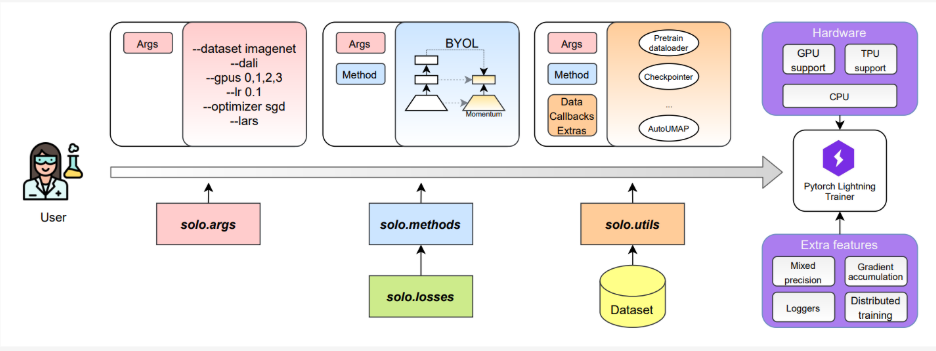

In [ ]:
!git clone https://github.com/vturrisi/solo-learn.git

Cloning into 'solo-learn'...
remote: Enumerating objects: 5302, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 5302 (delta 1), reused 1 (delta 1), pack-reused 5299 (from 2)
Receiving objects: 100% (5302/5302), 5.15 MiB | 8.42 MiB/s, done.
Resolving deltas: 100% (3806/3806), done.


In [ ]:
%cd solo-learn

/content/solo-learn


In [ ]:
!pip install -e .

Obtaining file:///content/solo-learn
  Preparing metadata (setup.py) ... done
  Attempting uninstall: solo-learn
    Found existing installation: solo-learn 1.0.6
    Uninstalling solo-learn-1.0.6:
      Successfully uninstalled solo-learn-1.0.6
  Running setup.py develop for solo-learn


Changes need to be made to dino.yaml file:

>max_epoch = 10 to avoid too much time for execution

In [ ]:
!python3 /content/solo-learn/main_pretrain.py --config-path /content/solo-learn/scripts/pretrain/cifar/ --config-name dino.yaml

2025-06-09 11:53:51.688945: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749470031.726369   17896 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749470031.737554   17896 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-09 11:53:51.769528: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.11/dist-packages/timm/models/helpers.py:7: FutureWarning: Importing from timm.models.helpers i